## Causal attention
**Causal attention**, also known as **masked attention**, is a specialized form of **self-attention**. <br>
It restricts a model to only consider previous and current inputs in a sequence when processing any given token. This is in contrast to the standard self-attention mechanism, which allows access to the entire input sequence at once. <br>
Consequently, when computing **attention scores**, the **causal attention** mechanism ensures that the model only factors in tokens that occur at or before the current token in the sequence.
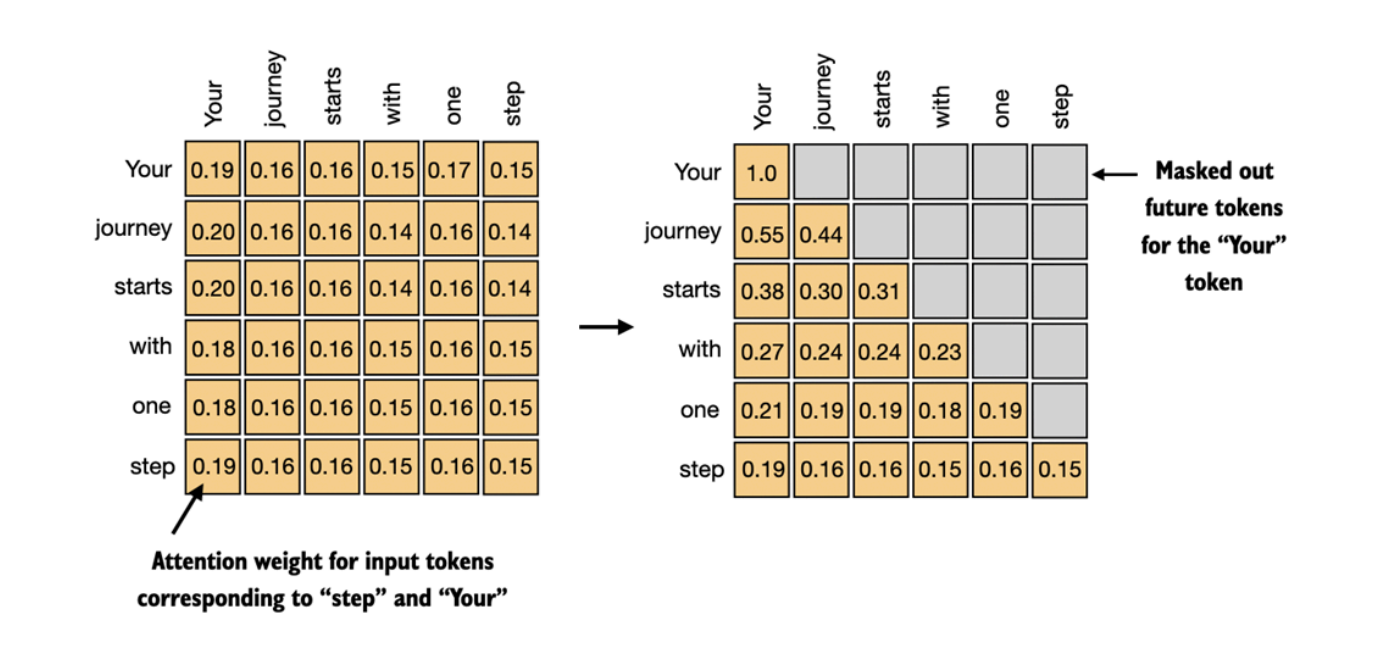 <br>
In **causal attention**, we mask out the attention weights above the diagonal such that for a given input, the LLM can't access future tokens when computing the context vectors using the attention weights. For example, for the word **journey** in the second row, we only keep the attention weights for the words before (**Your**) and in the current position (**journey**).

## Applying a causal attention mask <br>
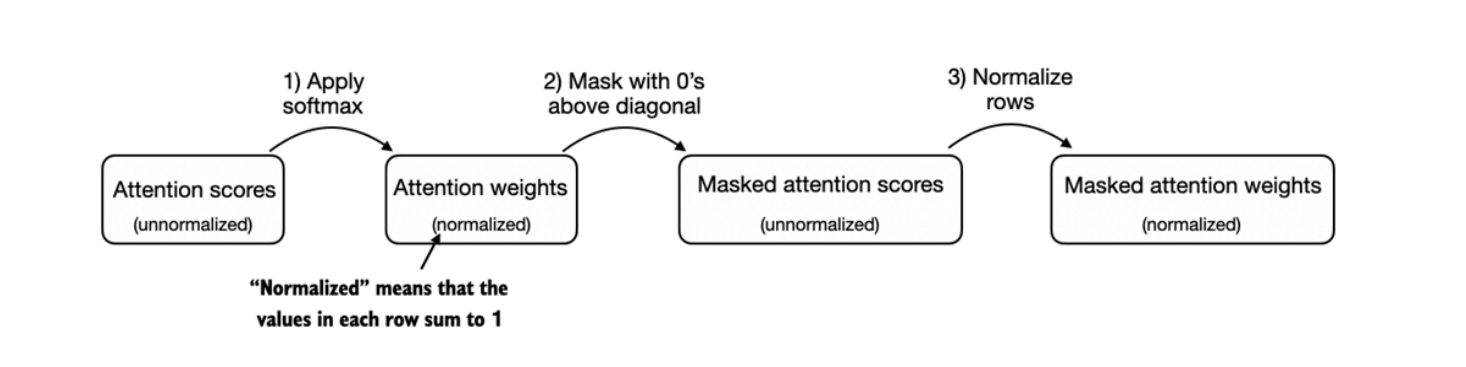 <br>
One way to obtain the masked attention weight matrix in **causal attention** is to apply the **softmax function** to the attention scores, zeroing out the elements above the diagonal and normalizing the resulting matrix.

In [2]:
import torch.nn as nn
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [21]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
    [0.55, 0.87, 0.66], # journey (x^2)
    [0.57, 0.85, 0.64], # starts (x^3)
    [0.22, 0.58, 0.33], # with (x^4)
    [0.77, 0.25, 0.10], # one (x^5)
    [0.05, 0.80, 0.55]] # step (x^6)
)
d_in = inputs.shape[1]
d_out = 2 

In [7]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [9]:
sa_v2.W_query(inputs)

tensor([[ 0.6600, -0.2047],
        [ 0.9091, -0.4471],
        [ 0.8960, -0.4419],
        [ 0.5034, -0.2633],
        [ 0.4088, -0.2232],
        [ 0.6628, -0.3292]], grad_fn=<MmBackward0>)

In [8]:
queries = sa_v2.W_query(inputs) #Reuse the query and key weight matrices of the SelfAttention_v2 object from the previous section for convenience
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [10]:
attn_scores

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)

In [14]:
attn_weights

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)

In [11]:
attn_scores.shape

torch.Size([6, 6])

We can implement **step 2** using **PyTorch's tril** function to create a mask where the values above the diagonal are zero:

In [12]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Now, we can multiply this **mask_simple** with the **attention weights** to zero out the values above the diagonal:

In [13]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


The **third step** is to **renormalize** the **attention weights** to sum up to 1 again in each row. We can achieve this by dividing each element in each row by the sum in each row:

In [15]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


While we could be technically done with implementing **causal attention** at this point, we can take advantage of a mathematical property of the **softmax function** and implement the computation of the **masked attention weights** more efficiently in fewer steps. <br>
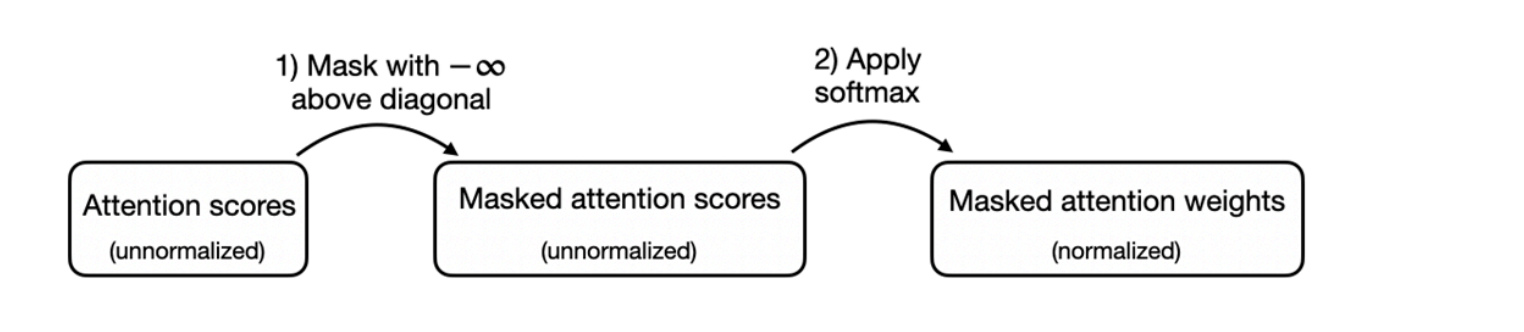 <br>
A more efficient way to obtain the masked attention weight matrix in causal attention is to mask the attention scores with negative infinity values before applying the softmax function.

The softmax function converts its inputs into a probability distribution. When negative infinity values (-∞) are present in a row, the softmax function treats them as zero probability. (Mathematically, this is because e -∞ approaches 0.) We can implement this more efficient masking "trick" by creating a mask with 1's above the diagonal and then replacing these 1's with negative infinity (-inf) values:

In [17]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [19]:
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
masked

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)

In [20]:
# Now, all we need to do is apply the softmax function to these masked results, and we are done:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


We could now use the modified **attention weights** to compute the **context vectors** via **context_vec = attn_weights @ values** as we have did that before.

### Masking additional attention weights with dropout
**Dropout** in deep learning is a technique where randomly selected hidden layer units are ignored during training, effectively "dropping" them out. This method helps prevent **overfitting** by ensuring that a model does not become overly reliant on any specific set of hidden layer units. It's important to emphasize that dropout is only used during training and is disabled afterward.
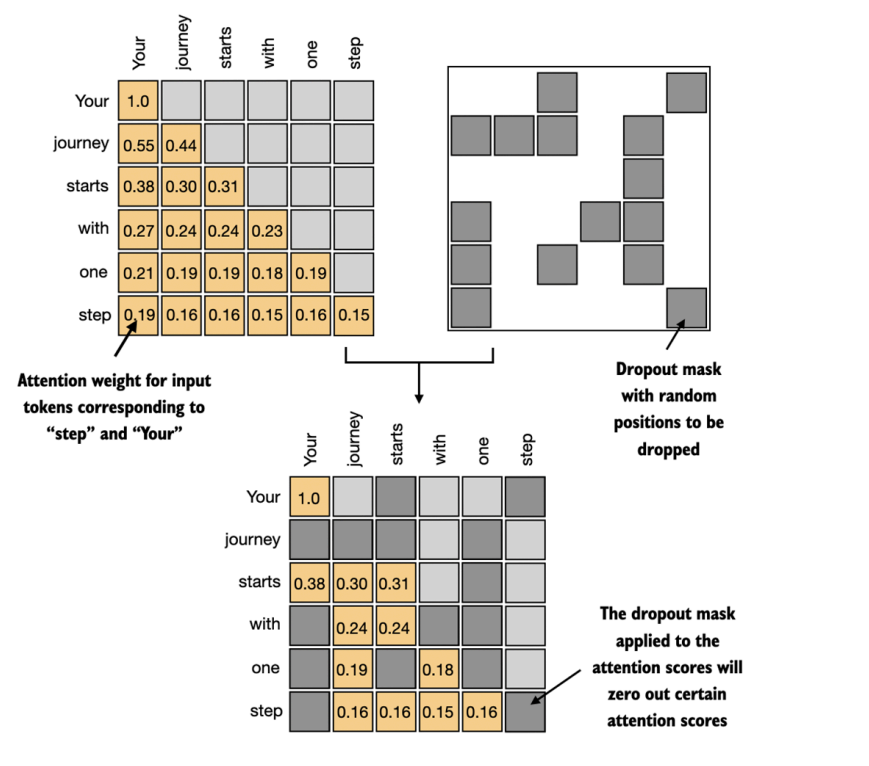

In [41]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #choose a dropout rate of 50%
example = torch.ones(6, 6) #we create a matrix of 1's
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [42]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


### Implementing a compact causal attention class

In [43]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [44]:
batch

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [45]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) #Compared to the previous SelfAttention_v1 class, we added a dropout layer
        self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length),
        diagonal=1)
        ) #B
    def forward(self, x):
        b, num_tokens, d_in = x.shape #The register_buffer call is also a new addition (more information is provided in the following text)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.transpose(1, 2) #We transpose dimensions 1 and 2, keeping the batch dimension at the first position (0)
        attn_scores.masked_fill_( # In PyTorch, operations with a trailing underscore are performed in-place, avoiding unnecessary memory copies
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        return context_vec

In [46]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])
